# FIGURE 2

In [19]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.figures.figure2 import plotR2YQ2Y, plotKmeansPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
from msresist.sequence_analysis import preprocess_seqs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [20]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)

ABC = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=False)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")


header = ABC.columns
treatments = ABC.columns[6:]

data = ABC.iloc[:, 6:].T
protnames = list(ABC.iloc[:, 0])
seqs = list(ABC.iloc[:, 1])

In [37]:
# ABC

### Phenotypes

#### Cell Viability:

In [22]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

## 1. Cross-validation

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [23]:
ncl = 2

In [24]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

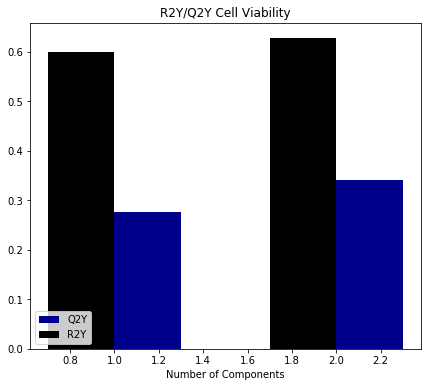

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [26]:
# fig, ax = plt.subplots(1, 1)
# plotKmeansPLSR_GridSearch(ax, data, Y_cv)

In [27]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# CVresults_max, CVresults_min, best_params = kmeansPLSR_tuning(data, Y_cv)

In [28]:
# CVresults_min.sort_values(by="Ranking").iloc[:20, :]

## 2. Model Predicted vs Actual for best Hyperparameter Set

In [29]:
ncl, ncomp = 2, 2

### 2.1 With CV Strategy 1:

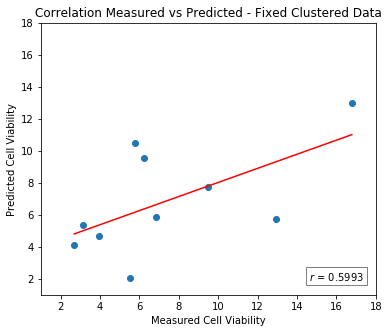

In [30]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

plotMeasuredVsPredicted(ax, PLSRegression(ncomp), centers, Y_cv)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data");

### 2.2 With CV Strategy 2:

In [31]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)

In [32]:
X_scores, Y_scores = kmeans_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = kmeans_plsr.named_steps.plsr.x_loadings_[:, 0], kmeans_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = kmeans_plsr.named_steps.plsr.y_loadings_[:, 0], kmeans_plsr.named_steps.plsr.y_loadings_[:, 1]

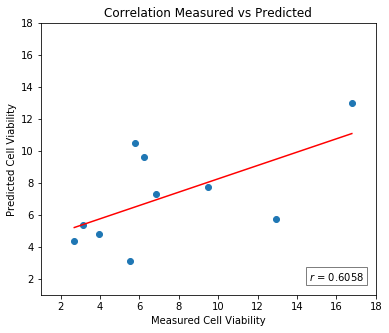

In [33]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, kmeans_plsr, data, Y_cv)

## 3. PLSR scores and loadings 

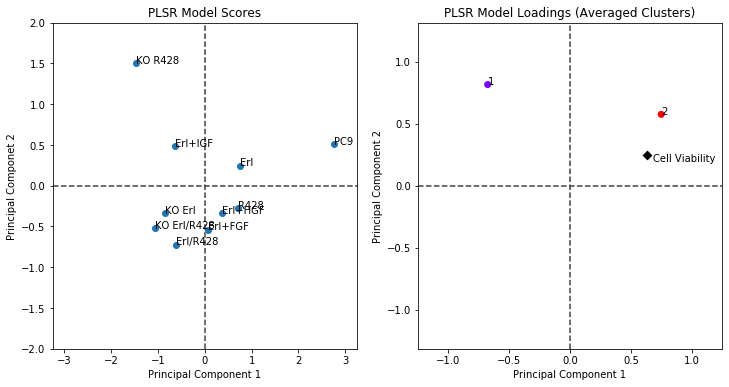

In [34]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Componet 2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
spacer = 0.5
axs[0].set_xlim([(-1*max(PC1_scores))-spacer, max(PC1_scores)+spacer])
axs[0].set_ylim([(-1*max(PC2_scores))-spacer, max(PC2_scores)+spacer])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].annotate("Cell Viability", (PC1_yload+0.05, PC2_yload-0.05))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([(-1*max(list(PC1_xload)+list(PC1_yload)))-spacer, max(list(PC1_xload)+list(PC1_yload))+spacer])
axs[1].set_ylim([(-1*max(list(PC2_xload)+list(PC2_yload)))-spacer, max(list(PC2_xload)+list(PC2_yload))+spacer]);

In [35]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC.T)
clustermembers

,Cluster_1,seqs_Cluster_1,UniprotAcc_Cluster_1,pos_Cluster_1,r2/Std_Cluster_1,BioReps_Cluster_1,Cluster_2,seqs_Cluster_2,UniprotAcc_Cluster_2,pos_Cluster_2,r2/Std_Cluster_2,BioReps_Cluster_2
0,60S ribosomal protein L22-like 1,TYELRyFQISQ,Q6P5R6,Y108-p,NA,1,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,P19174,Y783-p,NA,1
1,ADP/ATP translocase 2,ANVIRyFPTQA,P05141,Y81-p,NA,1,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,Y131-p,NA,1
2,ARF GTPase-activating protein GIT1,GADSDyENTQS,Q9Y2X7,Y598-p,NA,1,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,Y48-p,NA,1
3,Actin-related protein 3,EPEDHyFLLTE,P61158,Y109-p,NA,1,ADP-ribosylation factor-like protein 11,KtTLLyKLKGH,Q969Q4,Y30-p,0.94,2
4,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR,P54819,Y12-p,NA,1,ARF GTPase-activating protein GIT1,DDQHDyDSVAS,Q9Y2X7,Y383-p,NA,1
5,Bifunctional purine biosynthesis protein PURH,QMPLRyGMNPH,P31939,Y208-p,NA,1,ATPase WRNIP1,AGEEHyNCISA,Q96S55,Y500-p,NA,1
6,Breast cancer anti-estrogen resistance protein 1,PAPDLyDVPPG,P56945,Y372-p,NA,1,Abl interactor 2,VVPNDyVPSPT,Q9NYB9,Y213-p,NA,1
7,Cyclin-dependent kinase 1,IGEGTyGVVYK,P06493,Y15-p,0.98,3,Actin filament-associated protein 1-like 2,DEEYIyMNKVT,Q8N4X5,Y56-p,NA,1
8,Cyclin-dependent kinase 1,IGEGtyGVVYK,P06493,Y15-p,0.43,3,Actin filament-associated protein 1-like 2,SPDHLySFRIL,Q8N4X5,Y413-p,NA,1
9,Cyclin-dependent kinase 17,LGEGTyATVYK,Q00537,Y203-p,NA,1,"Actin, cytoplasmic 1",LTERGySFTTT,P60709,Y198-p,0.29,3


#### Cluster Averages across Conditions

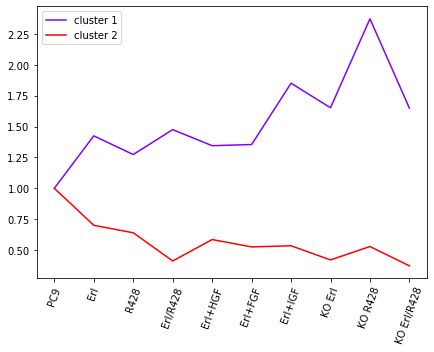

In [36]:
fig = plt.figure(figsize=(7,5))

centers = kmeans_plsr.named_steps.kmeans.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);